### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [6]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [7]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Remove the noise from the spectra using Savitzky–Golay-filtering

In [8]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 7
poly_order = 3

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = savgol_filter(df['Absorbance'], window_size, poly_order)

Then carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [9]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

lam = 10**3  # Adjust the regularisation parameter
p = 0.01    # Adjust the asymmetry parameter
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: baseline_als(x, lam=lam, p=p))

Remove the noise from the spectra using Savitzky–Golay-filtering

In [10]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 7
poly_order = 3

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = savgol_filter(df['Baseline_Corrected_Absorbance'], window_size, poly_order)

## 1 Sample Example

In [11]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Smoothed_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [13]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

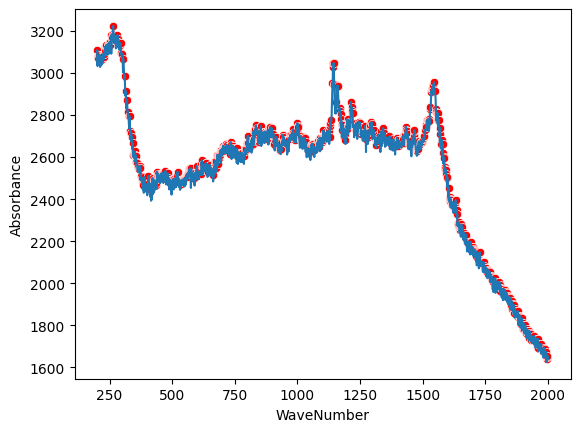

In [14]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

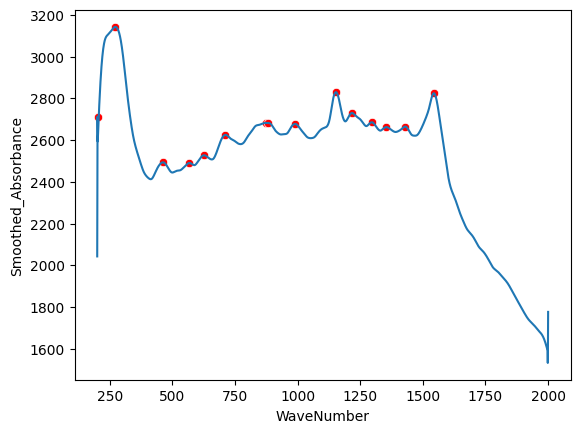

In [15]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

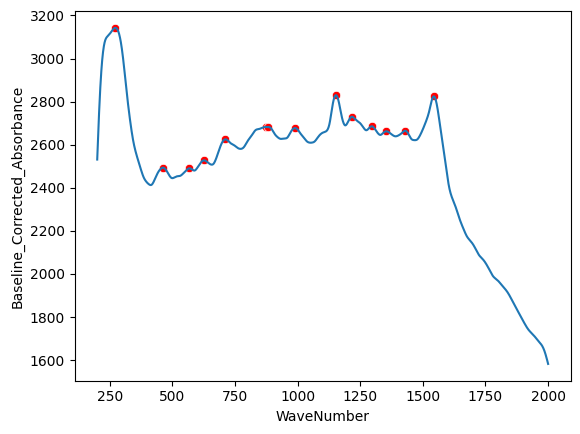

In [16]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

The average baseline corrected spectrum of each status

#### Machine Learning

In [17]:
spectra_df = df.drop(columns=['Absorbance', 'Smoothed_Absorbance'])

In [18]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [19]:
spectra_df = spectra_df.rename(columns={'Baseline_Corrected_Absorbance':'Absorbance'})

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [20]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [21]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [22]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2654.033104,2650.502362,2646.972158,2643.443542,2639.918012,2636.397436,2632.883921,2629.379847,2625.887878,2622.410856,...,970.517892,964.663500,958.742791,952.769910,946.760414,940.731238,934.700736,928.688719,922.684698,Normal
201210-1-01,2417.749679,2433.853833,2449.893565,2465.808987,2481.547184,2497.060129,2512.304415,2527.241064,2541.835387,2556.056788,...,1126.853794,1120.284058,1113.637015,1106.929456,1100.179721,1093.407817,1086.635519,1079.886473,1073.147428,Normal
201210-1-02,2936.604711,2953.386410,2970.092853,2986.654525,3003.010664,3019.106601,3034.893606,3050.328445,3065.373005,3079.993850,...,1671.134856,1657.291108,1643.244102,1629.037429,1614.718871,1600.340586,1585.959260,1571.636194,1557.338351,Normal
201210-1-03,6532.873950,6631.606499,6729.938283,6827.481677,6923.871199,7018.758315,7111.811892,7202.718964,7291.185382,7376.936287,...,1603.904732,1597.867115,1591.769339,1585.624178,1579.445570,1573.248820,1567.050670,1560.869323,1554.695281,Normal
201210-1-04,2940.846120,2956.179842,2971.448530,2986.591423,3001.554439,3016.288265,3030.748116,3044.893480,3058.687951,3072.099095,...,1611.124567,1604.562943,1597.931910,1591.246623,1584.523674,1577.781174,1571.038827,1564.317988,1557.606415,Normal


#### Training a Neural Network on the full spectrum.

In [118]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [147]:
bins_and_spectrum = pd.read_csv("../../data/raw_spec_and_max_bins.csv")

/tmp/ipykernel_6009/2101531672.py:1: DtypeWarning: Columns (19,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,45,46,47,91,98,99,100,101,102,103,104,105,106,107,108,109,110,112,113,117,118,119,163,170,171,172,173,174,175,176,177,178,179,180,181,182,184,185,189,190,191) have mixed types. Specify dtype option on import or set low_memory=False.
  bins_and_spectrum = pd.read_csv("../../data/raw_spec_and_max_bins.csv")


In [148]:
bins_and_spectrum = bins_and_spectrum.set_index('SpecID')
bins_and_spectrum = bins_and_spectrum.replace(False, 0, inplace=True)

In [149]:
X = bins_and_spectrum.drop(['Status'], axis=1)
y = bins_and_spectrum['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

AttributeError: 'NoneType' object has no attribute 'drop'

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

Encode the labels as numerical values

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

One-hot encoding should be used for multiclass classification

In [ ]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)

Create a validation set

In [ ]:
print(len(y_train_one_hot))

2436


In [ ]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=1234)

Standardise the features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

ValueError: could not convert string to float: 'False'

In [ ]:
X.shape

(3045, 2635)

Define the model parameters

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D

# model = Sequential()
# model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(GlobalAveragePooling1D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(3, activation='softmax'))

In [ ]:
# model = Sequential()
# model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))  # Change activation based on your task

Compile the model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )

Train the model

In [ ]:
model.fit(X_train_scaled, y_train_one_hot, epochs=1000, batch_size=32, validation_data=(X_val_scaled, y_val_one_hot))

Epoch 1/1000


39/39 [==============================] - 2s 22ms/step - loss: 1.2032 - accuracy: 0.4848 - val_loss: 1.7089 - val_accuracy: 0.5160
Epoch 2/1000
39/39 [==============================] - 1s 19ms/step - loss: 1.0763 - accuracy: 0.5225 - val_loss: 1.2678 - val_accuracy: 0.4968
Epoch 3/1000
39/39 [==============================] - 1s 18ms/step - loss: 0.9752 - accuracy: 0.5674 - val_loss: 1.2660 - val_accuracy: 0.5385
Epoch 4/1000
39/39 [==============================] - 1s 19ms/step - loss: 1.0661 - accuracy: 0.5120 - val_loss: 1.1052 - val_accuracy: 0.5288
Epoch 5/1000
39/39 [==============================] - 1s 19ms/step - loss: 0.9856 - accuracy: 0.5498 - val_loss: 0.9666 - val_accuracy: 0.5481
Epoch 6/1000
39/39 [==============================] - 1s 19ms/step - loss: 0.9911 - accuracy: 0.5490 - val_loss: 0.9122 - val_accuracy: 0.5353
Epoch 7/1000
39/39 [==============================] - 1s 19ms/step - loss: 0.9794 - accuracy: 0.5634 - val_loss: 1.0170 - val_accuracy: 0.5385
Epoch 8/1000

Evaluate the model

In [ ]:
y_pred = model.predict(X_test_scaled)
decoded_predictions = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(decoded_predictions.round().astype(int))  # Convert the labels back to strings
calculate_metrics(y_test, y_pred_labels)

20/20 [==============================] - 0s 2ms/step
Overall Accuracy: 0.8275862068965517


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.82      0.77      0.80       203
 Hypoglycemia       0.90      0.83      0.87       200
       Normal       0.77      0.87      0.82       206

     accuracy                           0.83       609
    macro avg       0.83      0.83      0.83       609
 weighted avg       0.83      0.83      0.83       609


Confusion Matrix:
[[157  11  35]
 [ 15 167  18]
 [ 19   7 180]]
